![Manhattan Urban Forest](cover.png)

# Which tree species should the city plant?

# 🎯 Aim

Advise the planning department on ways to improve the quantity and quality of trees in Manhattan.  
The urban design team believes tree size (using trunk diameter as a proxy for size) and health are the most desirable characteristics of city trees.

# 💡 Summary

> Toggle to show summary or use the link to go to the section for more detail

### Part 1: Exploratory Data Analysis
<details>
<summary>What are the most common tree species in Manhattan? [<a href="#1a">1.a.</a>]</summary>

- Honeylocust (21.1%)
- Callery Pear (11.7%)
- Ginkgo (9.4%)
- Pin Oak (7.3%)
- Sophora (7.1%)

<img src="figs/species.png">
</details>

<details>
<summary>Which are the neighborhoods with the most trees? [<a href="#1b">1.b.</a>]</summary>

- By number:
    - Upper West Side (5723)
    - Upper East Side-Carnegie Hill (4540)
    - West Village (3715)
- By density:
    - Upper East Side-Carnegie Hill
    - Central Harlem South
    - Upper West Side

Note: This does not include the "_park-cemetery-etc-Manhattan_" neighbourhood for which no tree data is provided.

<img src="figs/density.png">
</details>

<details>
<summary>A visualization of Manhattan's neighborhoods and tree locations. [<a href="#1c">1.c.</a>]</summary>
Go to [<a href="#1c">1.c.</a>] for explanation of figure

<img src="figs/trees.png">
</details>

### Part 2: Modelling & Recommendations
<details>
<summary>What ten tree species would you recommend the city plant in the future? [<a href="#2">2.</a>]</summary>
<img src="tree_recommendations.png">
    
Image attributions can be found at the end of the notebook.
</details>

# 🧭 Part 1: Exploratory Data Analysis

In [1]:
# IMPORTS ==============================================================
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

import src.style # A file which helps me style all the plots more consistently

### Load Data

The team has provided access to the 2015 tree census and geographical information on New York City neighborhoods ([trees](https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh), [neighborhoods](https://data.cityofnewyork.us/City-Government/NTA-map/d3qk-pfyz)):

#### Tree Census
- "tree_id" - Unique id of each tree.
- "tree_dbh" - The diameter of the tree in inches measured at 54 inches above the ground.
- "curb_loc" - Location of the tree bed in relation to the curb. Either along the curb (OnCurb) or offset from the curb (OffsetFromCurb).
- "spc_common" - Common name for the species.
- "status" - Indicates whether the tree is alive or standing dead.
- "health" - Indication of the tree's health (Good, Fair, and Poor).
- "root_stone" - Indicates the presence of a root problem caused by paving stones in the tree bed.
- "root_grate" - Indicates the presence of a root problem caused by metal grates in the tree bed.
- "root_other" - Indicates the presence of other root problems.
- "trunk_wire" - Indicates the presence of a trunk problem caused by wires or rope wrapped around the trunk.
- "trnk_light" - Indicates the presence of a trunk problem caused by lighting installed on the tree.
- "trnk_other" - Indicates the presence of other trunk problems.
- "brch_light" - Indicates the presence of a branch problem caused by lights or wires in the branches.
- "brch_shoe" - Indicates the presence of a branch problem caused by shoes in the branches.
- "brch_other" - Indicates the presence of other branch problems.
- "postcode" - Five-digit zip code where the tree is located.
- "nta" - Neighborhood Tabulation Area (NTA) code from the 2010 US Census for the tree.
- "nta_name" - Neighborhood name.
- "latitude" - Latitude of the tree, in decimal degrees.
- "longitude" - Longitude of the tree, in decimal degrees.

#### Neighborhoods' geographical information
- "ntacode" - NTA code (matches Tree Census information).
- "ntaname" - Neighborhood name (matches Tree Census information).
- "geometry" - Polygon that defines the neighborhood.

_Tree census and neighborhood information from the City of New York [NYC Open Data](https://opendata.cityofnewyork.us/data/)._

In [2]:
# READ TREES CSV & PRINT BASIC FACTS ===================================
trees = pd.read_csv('data/trees.csv')
print("Latitude Range:", trees.latitude.min(), trees.latitude.max())
print("Longitude Range:", trees.longitude.min(), trees.longitude.max())
print("Duplicated tree_id:", trees.tree_id.value_counts().max()>2)
print("Number of trees:", len(trees), trees.status.value_counts().to_dict())
print("Number of unique species of tree:")
trees.head(1)

Latitude Range: 40.70178954 40.87305363
Longitude Range: -74.01836049 -73.91120169
Duplicated tree_id: False
Number of trees: 64229 {'Alive': 62427, 'Dead': 1802}
Number of unique species of tree:


,tree_id,tree_dbh,curb_loc,spc_common,status,health,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,postcode,nta,nta_name,latitude,longitude
0,190422,11,OnCurb,honeylocust,Alive,Good,No,No,No,No,No,No,No,No,No,10023,MN14,Lincoln Square,40.770046,-73.98495


In [3]:
# READ NTA SHP DATA & PRINT BASIC FACTS ================================
neighborhoods = gpd.read_file('data/nta.shp')
print("Number of Manhattan neighbourhoods:", neighborhoods[neighborhoods["boroname"]=="Manhattan"]["ntaname"].nunique())
print(
    "No trees in the following neighborhoods of Manhattan:",
    set(neighborhoods[neighborhoods["boroname"]=="Manhattan"]["ntaname"].unique()) - set(trees["nta_name"].unique())
)

neighborhoods['point'] = neighborhoods['geometry'].apply(lambda x: x.centroid.coords[0])
neighborhoods.head(1)

Number of Manhattan neighbourhoods: 29
No trees in the following neighborhoods of Manhattan: {'park-cemetery-etc-Manhattan'}


,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry,point
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((-73.94733 40.62917, -73.94687 40.626...","(-73.95682460579987, 40.620924048798294)"


### Missing Data for Dead Trees<a id="missing"><a>

**Oberservations from the data**
- A very small proportion of trees (2.8%) in the data are dead
- NAN values:
    - "spc_common", "health" are the only columns with missing values.
    - "health" is missing if and only if the tree is dead.
    - If "spc_common" is missing, then the tree is dead.
    - There is only one tree where the tree is dead but "spc_common" is not missing ("honeylocust").
- Pre-filled values:
    - Y/N conditions (e.g "root_stone", "root_grate") for dead trees are always "No". It is likely that these are pre-filled/defaults and that this info was not actually collected for dead trees (i.e should be treated like NAN-s).
- Living trees do not have any missing data.

**Consequently...**
- We cannot use "status" to decide which species are better.
- We cannot associate Y/N conditions with "status".
- Later in Part 2, we can use only the living trees. When we do, we will have no missing values and still a large dataset.
- In 1.a, in/excluding the one dead tree for which species is known will not impact species rankings.

In [47]:
print(
    "Proportion of trees Alive/Dead:",
    (trees["status"].value_counts() / len(trees)).round(3).to_dict()
)

print(
    "Any missing values for living trees?", 
    trees[trees.status == "Alive"].isna().any().any()
)

print("The only dead tree where 'spc_common' is given:")
trees[(trees["status"]=="Dead") & (~trees["spc_common"].isna())]


Proportion of trees Alive/Dead: {'Alive': 0.972, 'Dead': 0.028}
Any missing values for living trees? False
The only dead tree where 'spc_common' is given:


,tree_id,tree_dbh,curb_loc,spc_common,status,health,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,postcode,nta,nta_name,latitude,longitude
28539,473703,12,OffsetFromCurb,honeylocust,Dead,NaN,No,No,No,No,No,No,No,No,No,10002,MN28,Lower East Side,40.710384,-73.988208


In [48]:
print("Value proportions for some categorical columns of `trees`:")

props = pd.DataFrame()
props["Status=Any"] = trees.fillna("NAN").drop(columns=["spc_common", "tree_id", "tree_dbh", "postcode", "nta", "nta_name", "longitude", "latitude"]) \
    .apply(lambda s: (s.value_counts() / len(s)).round(3).to_dict(), axis=0)
props["Status=Dead"] = trees[trees.status == "Dead"].fillna("NAN").drop(columns=["spc_common", "tree_id", "tree_dbh", "postcode", "nta", "nta_name", "longitude", "latitude"]) \
    .apply(lambda s: (s.value_counts() / len(s)).round(3).to_dict(), axis=0)
    
pd.options.display.max_colwidth = None
props

Value proportions for some categorical columns of `trees`:


,Status=Any,Status=Dead
curb_loc,"{'OnCurb': 0.933, 'OffsetFromCurb': 0.067}","{'OnCurb': 0.956, 'OffsetFromCurb': 0.044}"
status,"{'Alive': 0.972, 'Dead': 0.028}",{'Dead': 1.0}
health,"{'Good': 0.737, 'Fair': 0.178, 'Poor': 0.056, 'NAN': 0.028}",{'NAN': 1.0}
root_stone,"{'No': 0.804, 'Yes': 0.196}",{'No': 1.0}
root_grate,"{'No': 0.961, 'Yes': 0.039}",{'No': 1.0}
root_other,"{'No': 0.922, 'Yes': 0.078}",{'No': 1.0}
trunk_wire,"{'No': 0.986, 'Yes': 0.014}",{'No': 1.0}
trnk_light,"{'No': 0.995, 'Yes': 0.005}",{'No': 1.0}
trnk_other,"{'No': 0.913, 'Yes': 0.087}",{'No': 1.0}
brch_light,"{'No': 0.986, 'Yes': 0.014}",{'No': 1.0}


### 1.a: Most Common Tree Species In Manhattan<a id="#1a"></a>

**Pie-chart**: The proportions of trees belonging to each species. The most common species are labelled with their common name and percentage.

In [49]:
# PLOT PIE CHART OF TREE COUNTS ========================================

def plot_tree_counts(data, num_labelled=8):
    counts = data["spc_common"].value_counts().to_frame("count") \
        .reset_index().rename(columns={"index": "spc_common"})
    counts["percent"] = counts["count"] / counts["count"].sum()
    counts["label"] = counts["spc_common"].str.title() + counts["percent"].apply(lambda x: f" ({x:.1%})")
    
    fig, ax = plt.subplots(1, 1)
    wedges, texts = ax.pie(counts["count"], wedgeprops=dict(width=0.5), startangle=-50)

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges[:num_labelled]):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(counts["label"].loc[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

    return fig, ax

fig, ax = plot_tree_counts(trees)
fig.suptitle("Species of Tree in Manhattan (Status=Any)", y=1.05);
# fig.savefig("figs/species.png", facecolor="white", bbox_inches="tight");
plt.close()

![Species](figs/species.png)
<!-- <img src="figs/species.png"> -->
<!-- <img src="figs/species_alive.png"> -->

- Honeylocust (21.1%)
- Callery Pear (11.7%)
- Ginkgo (9.4%)
- Pin Oak (7.3%)
- Sophora (7.1%)

### 1.b: Which Are The Neighborhoods With The Most Trees?<a id="#1b"></a>

**Left**: A map of Manhattan's neighborhoods colored by its total count of living trees. Darker color means more trees by total count.  
**Right**: A map of Manhattan's neighborhoods colored by its density of living trees. Darker color means more trees per area of neighborhood.

The number in each neighborhood is its ranking. Where "1" indicates the state had the most trees by total count or per area. The top 3 neighborhoods in each subplot are also labelled with red arrows and their names.

The grey hatched areas are of the "_park-cemetery-etc-Manhattan_" neighborhood which does not contain any trees in the data provided.

In [50]:
# SETUP FOR FOLLOWING GEOPANDAS MAP PLOTS ==============================
# SOME GEOPANDAS PLOTTING KWARGS ---------------------------------------
annot_kwargs = dict(
    textcoords='axes fraction',
    arrowprops=dict(color='red', shrink=0.05),
    horizontalalignment='right', 
    verticalalignment='top', 
    xycoords='data'
)
missing_kwds = {
    "facecolor": "lightgrey",
    "edgecolor": "grey",
    "hatch": "///",
}

# A TWO PANEL LAYOUT I WILL USE REPEATEDLY -----------------------------
def dual_layout(suptitle, titles, figsize=(18, 20), y=0.82):
    fig, ax = plt.subplots(1, 2, figsize=(18, 20))
    fig.suptitle(suptitle, y=y, fontsize=16)
    for i, a in enumerate(ax):
        a.set_title(titles[i], fontsize=16)
        a.set_xlabel("longitude", fontsize=12)
        a.set_ylabel("latitude", fontsize=12)
    return fig, ax

# SOME OBJECTS TO ENABLE CUSTOM LEGENDS --------------------------------
import matplotlib.patches as mpatches
class AnyObject(object):
    pass

class AnyObjectHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpatches.Rectangle([x0, y0], width, height, lw=1,
                                   transform=handlebox.get_transform(),
                                   **missing_kwds)
        handlebox.add_artist(patch)
        return patch

In [51]:
# PLOTTING NEIGHBORHOOD TREE COUNTS AND DENSITIES ======================
# PREP DATA ------------------------------------------------------------
d = pd.DataFrame()
d["Alive"] = trees[trees["status"]=="Alive"]["nta_name"].value_counts()
d["Dead"] = trees[trees["status"]=="Dead"]["nta_name"].value_counts()
d = d.reset_index()
d.columns = ["nta_name", "alive", "dead"]
d["total"] = d["alive"] + d["dead"]
d["survival"] = d["alive"] / d["total"]
d = d.append(pd.Series({"nta_name": 'park-cemetery-etc-Manhattan'}), ignore_index=True) #.fillna(0)
# print(d.head())

man = pd.merge(neighborhoods[neighborhoods["boroname"]=="Manhattan"], d, left_on="ntaname", right_on="nta_name")
assert man["boroname"].nunique() == 1
# print(man.head())

man["alive/area"] = man["alive"].divide(man["shape_area"])
man["alive_rank"] = man["alive"].rank(ascending=False)
man["alive/area_rank"] = man["alive/area"].rank(ascending=False)

# CREATE CANVAS --------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(19, 13))
fig.suptitle("Number & Density of Living Trees in Each Neighborhood", y=0.92, fontsize=16)
ax[0].set_title("Number of Living Trees", fontsize=16)
ax[1].set_title("Density of Living Trees", fontsize=16)
ax[0].set_xlabel("longitude", fontsize=14)
ax[0].set_ylabel("latitude", fontsize=14)
ax[1].set_xlabel("longitude", fontsize=14)
ax[1].set_ylabel("latitude", fontsize=14)

# PLOT MAP -------------------------------------------------------------
man.plot("alive", cmap="Greens", ax=ax[0], legend=True)
man.plot("alive/area", cmap="Greens", ax=ax[1], legend=True)
man[man.nta_name=="park-cemetery-etc-Manhattan"].plot(ax=ax[0], **missing_kwds)
man[man.nta_name=="park-cemetery-etc-Manhattan"].plot(ax=ax[1], **missing_kwds)

# ANNOTATIONS ----------------------------------------------------------
for i, row in man.iterrows():
    if row["nta_name"] != 'park-cemetery-etc-Manhattan':
        ax[0].annotate(int(row["alive_rank"]), xy=row["point"], color="white" if row["alive_rank"]==1 else "black")
        ax[1].annotate(int(row["alive/area_rank"]), xy=row["point"], color="white" if row["alive/area_rank"]==1 else "black")

# Annotate top neighbourhoods
man = man.sort_values("alive", ascending=False)
ax[0].annotate(man.iloc[0]["ntaname"], xy=man.iloc[0]["point"], xytext=(0.3, 0.6), **annot_kwargs)
ax[0].annotate(man.iloc[1]["ntaname"], xy=man.iloc[1]["point"], xytext=(0.95, 0.3), **annot_kwargs)
ax[0].annotate(man.iloc[2]["ntaname"], xy=man.iloc[2]["point"], xytext=(0.7, 0.15), **annot_kwargs)

man = man.sort_values("alive/area", ascending=False)
ax[1].annotate(man.iloc[0]["ntaname"], xy=man.iloc[0]["point"], xytext=(0.95, 0.3), **annot_kwargs)
ax[1].annotate(man.iloc[1]["ntaname"], xy=man.iloc[1]["point"], xytext=(0.5, 0.75), **annot_kwargs)
ax[1].annotate(man.iloc[2]["ntaname"], xy=man.iloc[2]["point"], xytext=(0.3, 0.6), **annot_kwargs)

man[["ntaname", "alive", "alive_rank", "alive/area", "alive/area_rank"]].to_csv("results/density.csv", index=False)

# LEGEND ---------------------------------------------------------------
ax[0].legend([AnyObject()], ['park-cemetery-etc-Manhattan'],
           handler_map={AnyObject: AnyObjectHandler()}, loc="upper left")
ax[1].legend([AnyObject()], ['park-cemetery-etc-Manhattan'],
           handler_map={AnyObject: AnyObjectHandler()}, loc="upper left")

# fig.savefig("figs/density.png", bbox_inches="tight", facecolor="white")
plt.close()

![Density](figs/density.png)
<!-- <img src="figs/density.png"> -->

- By number:
    - Upper West Side (5723)
    - Upper East Side-Carnegie Hill (4540)
    - West Village (3715)
- By density:
    - Upper East Side-Carnegie Hill
    - Central Harlem South
    - Upper West Side

### 1.c: A Visualization of Manhattan's Neighborhoods and Tree Locations<a id='1c'></a>

**Left**: A map of Manhattan's neighborhoods with neighborhood codes labelled.  
**Right**: A map of Manhattan's neighborhoods with green points showing locations of trees.  

Neighborhood code and tree locations are shown in side by side subplots because having them superimposed on the same plot makes it difficult to see some tree locations.

The grey hatched areas are of the "_park-cemetery-etc-Manhattan_" neighborhood which does not contain any trees in the data provided.

See Appendix B for a map of dead tree locations and another version using kernel density estimation to show the distribution of trees.

In [52]:
# SCATTERPLOT ON MAP SHOWING LIVING TREE LOCATIONS =====================
# CREATE CANVAS --------------------------------------------------------
fig, ax = dual_layout(
    suptitle="Manhattan's Neighborhoods and Tree Locations",
    titles=("Manhattan's Neighborhoods", "Manhattan's Tree Locations")
)

# PLOT MAP -------------------------------------------------------------
man[man.nta_name=="park-cemetery-etc-Manhattan"].plot(ax=ax[0], **missing_kwds)
man[man.nta_name=="park-cemetery-etc-Manhattan"].plot(ax=ax[1], **missing_kwds)
man.dropna().plot(ax=ax[0], cmap="Pastel1", edgecolor="black")
man.dropna().plot(ax=ax[1], cmap="Pastel1", edgecolor="black")

sns.scatterplot(data=trees, x="longitude", y="latitude", ax=ax[1],
                s=1, alpha=0.3,
                # hue="status",
                color="green"
                )

# ANNOTATIONS ----------------------------------------------------------
for i, row in man.dropna().iterrows():
    ax[0].annotate(row["ntacode"], xy=row["point"], 
        horizontalalignment="center", fontsize=10,
        verticalalignment="top")

# LEGEND ---------------------------------------------------------------
ax[0].legend([AnyObject()], ['park-cemetery-etc-Manhattan'],
           handler_map={AnyObject: AnyObjectHandler()}, loc="upper left")
ax[1].legend([AnyObject()], ['park-cemetery-etc-Manhattan'],
           handler_map={AnyObject: AnyObjectHandler()}, loc="upper left")

# fig.savefig("figs/trees.png", bbox_inches="tight", facecolor="white")
plt.close()

![Trees](figs/trees.png)
<!-- <img src="figs/trees.png"> -->

# 🧠 Part 2: Recommendations<a id='2'></a>

### Method

- Because of missing data for dead trees, we will only use living trees for this part of the analysis. More information can be found in the Load Data section of Part 1, <a href="#missing">here</a>.
- The "health" category assigned to each tree is transformed into an ordinal variable:
    - 0 = Poor
    - 1 = Fair
    - 2 = Good
- Species are excluded if they have fewer than 100 trees in manhattan.  
  This is because smaller samples are not a reliable indicator of how the tree might fair all around Manhattan (especially if the tree is also only concentrated in a few neighborhoods). Further analysis could give recommendations on a per neighborhood basis.
- Calculate species mean "health" and "tree_dbh"
- A species "overall_score" is computed by combining in equal parts the min-max normalised values for species mean "health" and "tree_dbh". The "overall_score" takes values from 0 to 1 where 1 is interpreted as a more suitable species to plant in Manhattan.  
$$\text{Species Overall Score (normed)}=\frac{\text{Species Mean Health (normed)} + \text{Species Mean Diameter (normed)}}{2}$$
- The species are ranked by their "overall_score" (higher is better)
- Check that the top species can be found in a fairly large number of neighbourhoods. Then the success of the species is more likely to be reproducible when planted anywhere in Manhattan.

In [53]:
# RECOMMENDATIONS ======================================================
# FILTER TO LIVING TREES ONLY ------------------------------------------
df = trees[trees.status == "Alive"].copy()
print(f"Proportion of trees alive (usable): {len(df)/len(trees):.1%}")

# HEALTH CATEGORY ->> ORDINAL ------------------------------------------
health_scores = ["Poor", "Fair", "Good"]
df["health"] = df["health"].map(lambda h: health_scores.index(h))

# PER SPECIES AGGREGATES -----------------------------------------------
df = df.groupby("spc_common").agg({
        "spc_common": ["count"], 
        "tree_dbh": ["mean", "std"], 
        "health": ["mean", "std"],
        "nta": ["nunique"],
    })

# COMPUTE OVERALL_SCORE ------------------------------------------------
def min_max_norm(column):
    return (column - column.min()) / (column.max() - column.min())
df[("overall_score", "mean")] = (min_max_norm(df[("health", "mean")]) + min_max_norm(df[("tree_dbh", "mean")])) / 2

# EXCLUDE SMALL SAMPLES ------------------------------------------------
df2 = df[df[("spc_common", "count")] >= 100].copy()

# RANK BY OVERALL_SCORE ------------------------------------------------
df2[("overall_score", "rank")] = df2[("overall_score", "mean")].rank(ascending=False)
# l = df2.sort_values(by=("overall_score", "mean"), ascending=False).head(10).index.to_list()
# print("\n".join([f"{r+1}. {name.title()}" for r, name in enumerate(l)]))
df2.sort_values(by=("overall_score", "mean"), ascending=False).head(10)

Proportion of trees alive (usable): 97.2%


spc_common   tree_dbh            ...     nta overall_score      
                      count       mean       std  ... nunique          mean  rank
spc_common                                        ...                            
American elm           1698  13.899293  9.703312  ...      28      0.918532   1.0
Siberian elm            156  12.064103  7.545714  ...      17      0.865607   2.0
willow oak              889  10.811024  9.331016  ...      27      0.825538   3.0
tree of heaven          104  11.451923  6.584595  ...      18      0.825422   4.0
London planetree       4122  13.168607  7.340801  ...      28      0.819583   5.0
pin oak                4584  10.068499  7.982340  ...      28      0.790423   6.0
black locust            259   9.768340  4.735689  ...      26      0.769029   7.0
honeylocust           13175   9.057837  3.997076  ...      28      0.764560   8.0
Sophora                4453   9.225915  4.892435  ...      28      0.750666   9.0
green ash               770   9.255844  4.371351  ...      27      0.729065  10.0

[10 rows x 8 columns]

### Conclusion

![Tree recommendations](tree_recommendations.png)
<!-- <img src="tree_recommendations.png" width="100%"> -->

1. American Elm
2. Siberian Elm
3. Willow Oak
4. Tree Of Heaven
5. London Planetree
6. Pin Oak
7. Black Locust
8. Honeylocust
9. Sophora
10. Green Ash

**Additional Analysis We Could Do**
- Improve the equation used to calculate "overall_score"
  - Include the other features such as presence of branch problems (although we cannot know from the data if these are causes or symptoms of ill health)
  - Estimate an error for "overall_score". This should be a function of errors in mean "health", "tree_dbh" as well as the number of trees of that species and how many/diverese neighborhoods it can be found in.
- Per neighborhood recommendations
  - Different trees may be more suited to certain neighborhoods
  - We could begin by looking at what species are most common in each neighborhood
  - We can also look at how growing conditions might differ between neighborhoods (e.g more on-curb trees due to narrower streets) which might affect health. Some species may be less affected.
- Compare "health" models fitted on all trees vs specific species
  - Model can be any regression method: linear, random forest, SVM, ...
  - Use growing conditions as features (similar to feature importance analysis in Appendix A)
  - Use "health" or "tree_dbh" as regression target (same as feature importance analysis in Appendix A)
  - Fit the model on all trees
  - For a given species, does the model tend to predict a "health" which is too high or too low? This may give some indication of which species are more sensitive to growing conditions and which are more resillient.
  - If there are interpretable coefficients (e.g linear regression) we can fit additional models on tree data for each species and compare them. This will show differences in the per unit effect of some growing conditions on one species vs another species.

### This Data Can't Tell The Whole Story ...

**Other Urban Planning Factors**
- Variety
    - Looks more natural
    - May protect trees from disease
- Invasive species
    - Invasive species may pose a risk to native species
    - The most common species may be invasive
    - It would be interesting to plot tree locations over time to see if some species are speading rapidly across new york.
- Conservation status
    - We should prioritise threatened species.
- Trees that look different during different seasons
    - Does the tree flower or produce fruits?
    - Does the tree stay green in the winter?
- Impact on wildlife
    - Does the tree produce fruits that feed desirable wildlife?
- Maintanence Cost
    - Do some trees grow faster than others and require more maintanence? (e.g pruning branches)
    - Are some trees more resistent to weathering and will not become hazards in strong winds?
    - If the tree looses it's leaves in the autumn, does it require cleaning to remove the leaves? (This may depend on street traffic)
- Neighborhood identity
    - Perhaps some neighborhoods have unique or recognizable trees and introducing a new species will change the identity of the neighborhood.
    - It could be worth surveying locals. But this might be difficult as most people do not know the names of many tree species.

**Data Quality Considerations**
- The [documentation](https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh "NYC OpenData") for the Tree Census data says "health" rating "_indicates the user's perception of tree health_".
    - This is subjective but likely to be a function of the other tree conditions recorded
    - We don't have multiple ratings for the same tree to assess rater agreement
    - We don't know the expertise of the "_volunteers and staff_" (e.g if they might miss a health problem that will kill the tree soon)
- The Tree Census data provided in the CSV does not have trees in some areas. 
    - The "_park-cemetery-etc-Manhattan_" neighborhood is one such area.
    - Satellite/terrain layers on Google Maps show these areas do have trees.
        - Parks do not seem to be included in the census. e.g the Brooklyn Bridge Park Piers, Fort Tryon Park, Riverside Park.
        - Some non-park areas also do not have any trees in the data provided. These seem to be separated polygons in our neighborhood shape data. e.g Roosevelt Island (part of nta Lenox Hill-Roosevelt Island, MN31), Marble Hill (part of nta Marble Hill-Inwood, MN01).
    - I believe some of this data was excluded for this competition: Navigating the [online map](https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/pi5s-9p35 "NYC OpenData") for the Tree Census, Marble Hill does have trees recorded.
    - If this missing data is not random, then this may bias the results. To fix this bias we could exclude some polygons when computing tree densities in 1.b.

# 📎 Appendix

### A. Predictors of Tree Health - Feature Importance Analysis

**Two Types of Feature Importance**
1. **MDI** = Mean decrease in impurity. A tree with less impurity separates the data better. If inclusion of a feature causes the mean impurity of trees in a forest to decrease more, then we can interpret this as the feature being more important to predicting the target.  
2. **Permutation**. For each feature, we permute (or shuffle) its values between the samples. This destroys that feature's association with the targt and other features. This way if the model's accuracy decreases (compared to before permuting) then we can interpret this as the feature being more important to predicting the target.

More info on this method can be found in this Sci-kit Learn [example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

In [54]:
# PRE-PROCESSING FOR FEATURE IMPORTANCE ANALYSIS =======================

df = trees[trees.status == "Alive"].copy()
print(f"Proportion of trees alive (usable): {len(df)/len(trees):.1%}")

# Encode the health categories as ordinal data -------------------------
health_scores = ["Poor", "Fair", "Good"]
df["health"] = df["health"].map(lambda h: health_scores.index(h))

# Transform binary data into booleans ----------------------------------
features_bin = [
    'root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trnk_light',
    'trnk_other', 'brch_light', 'brch_shoe', 'brch_other'
]
df[features_bin] = df[features_bin] == "Yes"
df["on_curb"] = df["curb_loc"] == "OnCurb"
df.drop(columns=["curb_loc"], inplace=True)
features_bin.append("on_curb")

# View the value proportions for the features --------------------------
df.drop(columns=["status"], inplace=True)
df.drop(columns=["spc_common", "tree_id", "tree_dbh", "postcode", "nta", "nta_name", "longitude", "latitude"]) \
    .apply(lambda s: (s.value_counts() / len(s)).round(3).to_dict(), axis=0)

Proportion of trees alive (usable): 97.2%


health        {2: 0.759, 1: 0.184, 0: 0.058}
root_stone       {False: 0.799, True: 0.201}
root_grate         {False: 0.96, True: 0.04}
root_other         {False: 0.92, True: 0.08}
trunk_wire       {False: 0.985, True: 0.015}
trnk_light       {False: 0.995, True: 0.005}
trnk_other       {False: 0.911, True: 0.089}
brch_light       {False: 0.986, True: 0.014}
brch_shoe        {False: 0.999, True: 0.001}
brch_other       {False: 0.895, True: 0.105}
on_curb          {True: 0.932, False: 0.068}
dtype: object

In [55]:
# DEFINE THE FEATURES AND REGRESSION TARGET ============================
features_cont = [
    'tree_dbh', 
]
features_cat = [
    'nta_name', 'spc_common', 
]
features = features_bin + features_cont + features_cat
target = "health" # categorical (ordinal)

In [56]:
# PAIRWISE CORRELATIONS BETWEEN FEATURES AND TARGET ====================
df1 = df[features_bin + features_cont + [target]]
cor = df1.corr()
# print(len(cor)) # 11 features + 1 target

cor.style.background_gradient(cmap='bwr', vmin=-1, vmax=1).set_precision(2)

,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,on_curb,tree_dbh,health
root_stone,1.00,-0.06,0.06,0.03,0.02,0.08,0.05,0.02,0.09,0.02,0.14,-0.05
root_grate,-0.06,1.00,0.03,0.00,0.04,0.05,0.02,0.00,0.04,0.00,-0.02,-0.04
root_other,0.06,0.03,1.00,0.03,0.04,0.20,0.03,0.01,0.18,0.04,0.05,-0.06
trunk_wire,0.03,0.00,0.03,1.00,0.09,0.02,0.16,-0.00,0.04,0.01,-0.01,-0.03
trnk_light,0.02,0.04,0.04,0.09,1.00,0.01,0.34,-0.00,0.01,0.00,0.00,-0.00
trnk_other,0.08,0.05,0.20,0.02,0.01,1.00,0.02,0.01,0.25,0.02,0.02,-0.15
brch_light,0.05,0.02,0.03,0.16,0.34,0.02,1.00,0.01,0.02,0.01,0.00,-0.03
brch_shoe,0.02,0.00,0.01,-0.00,-0.00,0.01,0.01,1.00,0.01,-0.01,0.01,-0.01
brch_other,0.09,0.04,0.18,0.04,0.01,0.25,0.02,0.01,1.00,0.04,0.00,-0.19
on_curb,0.02,0.00,0.04,0.01,0.00,0.02,0.01,-0.01,0.04,1.00,-0.14,-0.04


In [57]:
# CREATE THE RANDOM FOREST MODEL =======================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

features1 = features_bin + features_cont
X = df[features1]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123)

forest = RandomForestClassifier(random_state=0)
forest.feature_names_in_ = features1
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.7535080412635355

**Feature Importance Plots**  
In the plot for each type of feature importance, there is a bar for each feature
considered. The higher the bar the more important the feature. Each bar also
has an error bar.

We can see that "tree_dbh" (tree diameter in inches at 54 inches above ground) is the most important predictor of tree "health". This agrees with the urban planning team's belief that tree diameter is associated with tree health.

Additionally we see that "brch_other" (presence of other branch problems) is also a
significant feature for health.

In future it would also be interesting to repeat this analysis on a per species basis to find out if some species' health is more sensitive to root/trunk/branch problems or curb location.


Elapsed time to compute the importances: 0.014 seconds
Elapsed time to compute the importances: 13.037 seconds


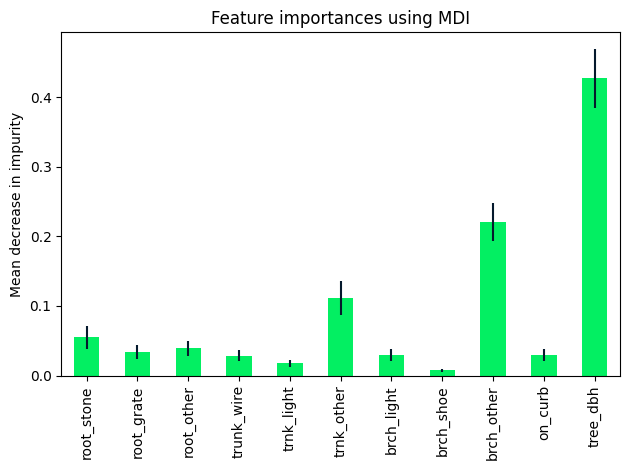

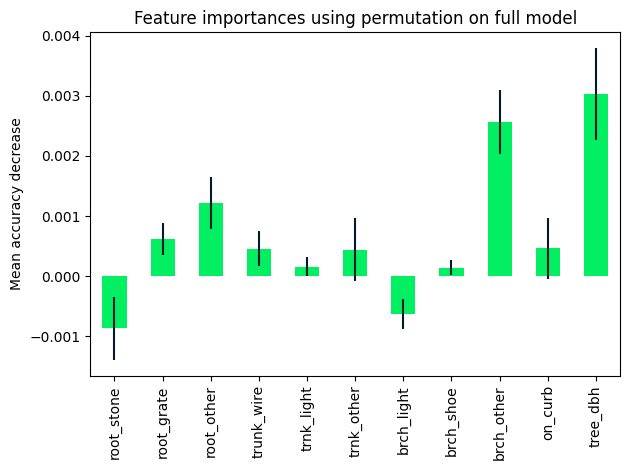

In [58]:
# COMPUTE & PLOT RESULTS FROM TWO TYPES OF FEATURE IMPORTANCE ==========
from src.forest_importance import *

forest_importances, std = mdi(forest)
fig, ax = plot_mdi(forest_importances, std);
# fig.savefig("figs/feature_importance_mdi.png", facecolor="white", bbox_inches="tight")
# plt.close()

forest_importances, std = perm(forest, X_test, y_test, random_state=123)
fig, ax = plot_perm(forest_importances, std);
# fig.savefig("figs/feature_importance_perm.png", facecolor="white", bbox_inches="tight")
# plt.close()

### B. Additional Plots for Manhattan Tree Locations

**Manhattan's Neighborhoods and Dead Tree Locations**  
**Left**: A map of Manhattan's neighborhoods with neighborhood codes labelled.  
**Right**: A map of Manhattan's neighborhoods with red points showing locations of dead trees.  

Neighborhood code and tree locations are shown in side by side subplots because having them superimposed on the same plot makes it difficult to see some tree locations.

The grey hatched areas are of the "_park-cemetery-etc-Manhattan_" neighborhood which does not contain any trees in the data provided.

In [59]:
# SCATTERPLOT ON MAP SHOWING DEAD TREE LOCATIONS =======================
# CREATE CANVAS --------------------------------------------------------
fig, ax = dual_layout(
    suptitle="Manhattan's Neighborhoods and Dead Tree Locations",
    titles=("Manhattan's Neighborhoods", "Manhattan's Dead Tree Locations")
)

# PLOT MAP -------------------------------------------------------------
man[man.nta_name=="park-cemetery-etc-Manhattan"].plot(ax=ax[0], **missing_kwds)
man[man.nta_name=="park-cemetery-etc-Manhattan"].plot(ax=ax[1], **missing_kwds)
man.dropna().plot(ax=ax[0], cmap="Pastel1", edgecolor="black")
man.dropna().plot(ax=ax[1], cmap="Pastel1", edgecolor="black")

sns.scatterplot(data=trees[trees.status=="Dead"], x="longitude", y="latitude", ax=ax[1],
                s=1, alpha=1,
                # hue="status",
                color="red"
                )

# ANNOTATIONS ----------------------------------------------------------
for i, row in man.dropna().iterrows():
    ax[0].annotate(row["ntacode"], xy=row["point"], 
        horizontalalignment="center", fontsize=10,
        verticalalignment="top")

# LEGEND ---------------------------------------------------------------
ax[0].legend([AnyObject()], ['park-cemetery-etc-Manhattan'],
           handler_map={AnyObject: AnyObjectHandler()}, loc="upper left")
ax[1].legend([AnyObject()], ['park-cemetery-etc-Manhattan'],
           handler_map={AnyObject: AnyObjectHandler()}, loc="upper left")

# fig.savefig("figs/trees_dead.png", bbox_inches="tight", facecolor="white")
plt.close()

![dead](figs/trees_dead.png)
<!-- <img src="figs/trees_dead.png"> -->

___

**Manhattan's Neighborhoods and Tree Density**  
**Left**: A map of Manhattan's neighborhoods with neighborhood codes labelled.  
**Right**: A map of Manhattan's neighborhoods with dark green points showing locations of trees AND a ligher green kernel density estimation of the distribution of trees.

Neighborhood code and tree locations are shown in side by side subplots because having them superimposed on the same plot makes it difficult to see some tree locations.

The grey hatched areas are of the "_park-cemetery-etc-Manhattan_" neighborhood which does not contain any trees in the data provided.

In [60]:
# KDEPLOT ON MAP SHOWING TREE DENSITY ==================================
# CREATE CANVAS --------------------------------------------------------
fig, ax = dual_layout(
    suptitle="Manhattan's Neighborhoods and Tree Density",
    titles=("Manhattan's Neighborhoods", "Manhattan's Tree Density (KDE)")
)

# PLOT MAP -------------------------------------------------------------
man[man.nta_name=="park-cemetery-etc-Manhattan"].plot(ax=ax[0], **missing_kwds)
man[man.nta_name=="park-cemetery-etc-Manhattan"].plot(ax=ax[1], **missing_kwds)
man.dropna().plot(ax=ax[0], cmap="Pastel1", edgecolor="black")

# COMPUTE KDE ----------------------------------------------------------
try:
    Z # Don't recalculate
except NameError:
    # xmax, ymax = trees[["longitude", "latitude"]].max()
    # xmin, ymin = trees[["longitude", "latitude"]].min()
    xmin, xmax = ax[0].get_xlim()
    ymin, ymax = ax[0].get_ylim()
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([trees["longitude"].values, trees["latitude"].values])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)

# PLOT MAP -------------------------------------------------------------
ax[1].scatter(trees["longitude"].values, trees["latitude"].values,
            s=0.5, 
            #   color="darkgreen", 
            color="black",
            alpha=0.2)
ax[1].imshow(np.rot90(Z),
             extent=[xmin, xmax, ymin, ymax],
             cmap=plt.cm.Greens)
man.boundary.plot(ax=ax[1], edgecolor="grey", linewidth=0.5)

# ANNOTATIONS ----------------------------------------------------------
for i, row in man.dropna().iterrows():
    ax[0].annotate(row["ntacode"], xy=row["point"], 
        horizontalalignment="center", fontsize=10,
        verticalalignment="top")

# LEGEND ---------------------------------------------------------------
ax[0].legend([AnyObject()], ['park-cemetery-etc-Manhattan'],
           handler_map={AnyObject: AnyObjectHandler()}, loc="upper left")
ax[1].legend([AnyObject()], ['park-cemetery-etc-Manhattan'],
           handler_map={AnyObject: AnyObjectHandler()}, loc="upper left")

# fig.savefig("figs/trees_kde.png", bbox_inches="tight", facecolor="white")
plt.close()

![kde](figs/trees_kde.png)
<!-- <img src="figs/trees_kde.png"> -->


### C. Boros of New York

**Map**: The 5 boros are shown in different colors. The outline of neighborhoods
in each boro is shown by a thin white outline. 

In [63]:
# PLOT THE BOROS OF NEW YORK ===========================================
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_title("Boros", fontsize=16)
ax.set_xlabel("longitude", fontsize=14)
ax.set_ylabel("latitude", fontsize=14)

neighborhoods.plot("boroname", ax=ax, 
                   legend=True, legend_kwds={"loc": "upper left"},
                   cmap=src.style.cmap,
                   )
# fig.savefig("figs/boros.png", facecolor="white", bbox_inches="tight")
plt.close()

![boros](figs/boros.png)
<!-- <img src="figs/boros.png"> -->

### D. Survivor Bias - We Have More Data on Healthy Trees Because They Survive

This can bias our results when trying to determine causes for death.

**Mean Species Diameter vs Health Score**  
**X**: Mean species Health where the categories poor/fair/good are treated as numbers 0/1/2  
**Y**: Mean species diameter in inches measured at 54 inches above the ground  

The size of the circles corresponds to how many trees there are of that species. This is only to show that there are more trees (larger circle) for species that tend to be rated healthier and have wider diameter. No species labels are included.

In [62]:
# DIAMETER VS HEALTH ===================================================
# FILTER TO LIVING TREES ONLY ------------------------------------------
df = trees[trees.status == "Alive"].copy()

# HEALTH CATEGORY ->> ORDINAL ------------------------------------------
health_scores = ["Poor", "Fair", "Good"]
df["health"] = df["health"].map(lambda h: health_scores.index(h))

# PER SPECIES AGGREGATES -----------------------------------------------
df = df.groupby("spc_common").agg({
        "spc_common": ["count"], 
        "tree_dbh": ["mean", "std"], 
        "health": ["mean", "std"],
        "nta": ["nunique"],
    })

# PLOT -----------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
minsize = df[("spc_common", "count")].min() / 2 + 10
maxsize = df[("spc_common", "count")].max() / 2
sns.scatterplot(
    data=df,
    ax=ax,
    x=("health", "mean"),
    y=("tree_dbh", "mean"),
    alpha=0.5, 
    size=("spc_common", "count"), sizes=(minsize, maxsize),
);

ax.set_title("Mean Species Diameter vs Health Score\n(Radius represents number of living trees for that species)")
ax.set_xlabel("Mean Species Health Score")
ax.set_ylabel("Mean Species Diameter (inches)")
ax.set_xticks(range(3));
ax.set_xticklabels(health_scores);
ax.legend().set_visible(False)
# fig.savefig("figs/diameter_vs_health.png", facecolor="white", bbox_inches="tight")
plt.close()

![diam_health](figs/diameter_vs_health.png)
<!-- <img src="figs/diameter_vs_health.png"> -->

# 📸 Image Attributions

- American Elm: By Marty Aligata - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=83143950
- Siberian Elm: By Greg Blick via flickr.com
- Willow Oak: By Freekhou5 - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=80043848
- Tree of Heaven: By Darkone (talk · contribs) - Own work, CC BY-SA 2.5, https://commons.wikimedia.org/w/index.php?curid=311698
- London Planetree: By Richard Croft, CC BY-SA 2.0, https://commons.wikimedia.org/w/index.php?curid=13601556
- Pin Oak: By Bruce Marlin - Own work http://www.cirrusimage.com/tree_pin_oak.htm, CC BY-SA 2.5, https://commons.wikimedia.org/w/index.php?curid=2525904
- Pin Oak in Autumn: By Famartin - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=36985645
- Black Locust Flowers: By Pollinator, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=2040096
- Black Locust: https://woodyinvasives.org/wp-content/uploads/2021/03/GLTR_form.jpg
- Honeylocust: By Kevmin - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=8267558
- Sophora: By Jean-Pol GRANDMONT - Own work, CC BY 3.0, https://commons.wikimedia.org/w/index.php?curid=5618874
- Green Ash: Paul Wray, Iowa State University

# ❤️ Wow!  
# I can't believe you made it all the way to the end thank you so much!  
Critical feedback much welcomed